# Set Up Imports

In [1]:
import numpy as np
import pandas as pd
import bqplot.pyplot as blt
import matplotlib.pyplot as plt

import time
import datetime as dt

import pysparkling

conn = pysparkling.Context()

from ipywidgets import interact

%matplotlib inline

# Load Data

We're going to use the `pandas` module to load the data, as its csv stuff is really nice.

In [2]:
data = pd.read_csv('netapp.csv', header=0,
                   names=['date', 'system', 'controller', 'obs_time',
                          'base_time', 'delta', 'release', 'fw', 'sw'],
                   dtype={'system': object})

Now we want to look at the what the rows look like.

In [3]:
data.head()

,date,system,controller,obs_time,base_time,delta,release,fw,sw
0,1/1/15,1016FG000254,A,1420149619,1420063224,86395,Galena,07.86.34.00,10.86.0G00.0028
1,1/1/15,1016FG000432,A,1420125162,1420091715,33447,Galena,07.86.36.30,10.86.0G00.0048
2,1/1/15,1017FG000057,A,1420102145,1420015747,86398,Galena,07.86.29.00,10.86.0G08.0017
3,1/1/15,1030FG000606,A,1420111809,1420044906,66903,Galena,07.86.45.30,10.86.0G00.0048
4,1/1/15,1030FG000619,A,1420112025,1420111359,666,Galena,07.86.45.30,10.86.0G00.0048


# Analyze Data

We will first examine the integrity of the overall dataset.

## Delta Time Distribution

This first plot looks at the time distribution of the deltas. Ideally we would see a flat line at approx. 86,000. We don't see that.

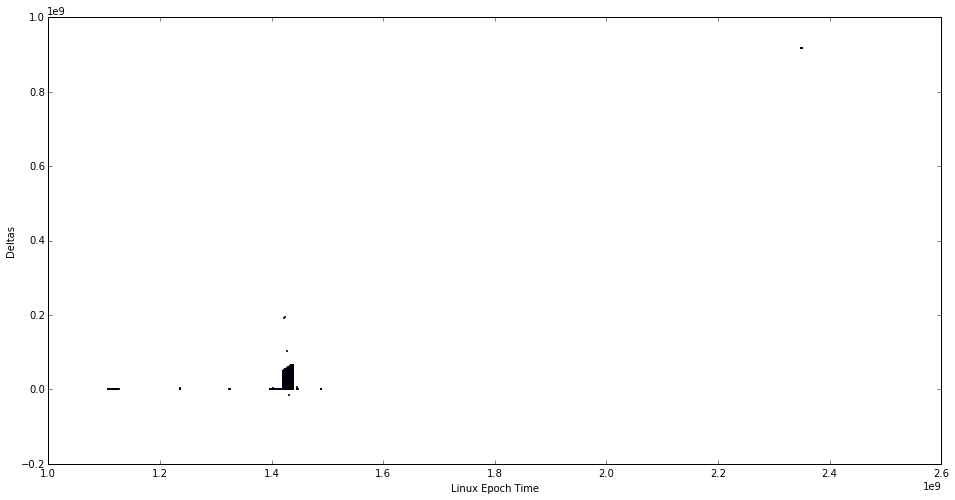

In [4]:
plt.figure(figsize=(16, 8))
plt.scatter(data['obs_time'], data['delta'], s=1)
plt.xlabel('Linux Epoch Time')
plt.ylabel('Deltas')
plt.show()

## Mean and Standard Deviation

We now examine the mean and standard deviation of the deltas for each system. First we generate our data. We will be setting a standard deviation threshold of one hour. Any system data that falls in the deviation we will call "good".

In [5]:
thresh = 3600
grouping = data.groupby('system')
size = len(grouping)
stat_data = np.zeros((size, 4))
i = 0
for key, group in grouping:
    deltas = group['delta']
    stat_data[i][0] = deltas.mean()
    stat_data[i][1] = deltas.std()
    stat_data[i][2] = len(deltas)
    stat_data[i][3] = (255 if deltas.std() <= thresh else 0)
    i += 1

We can plot these results.

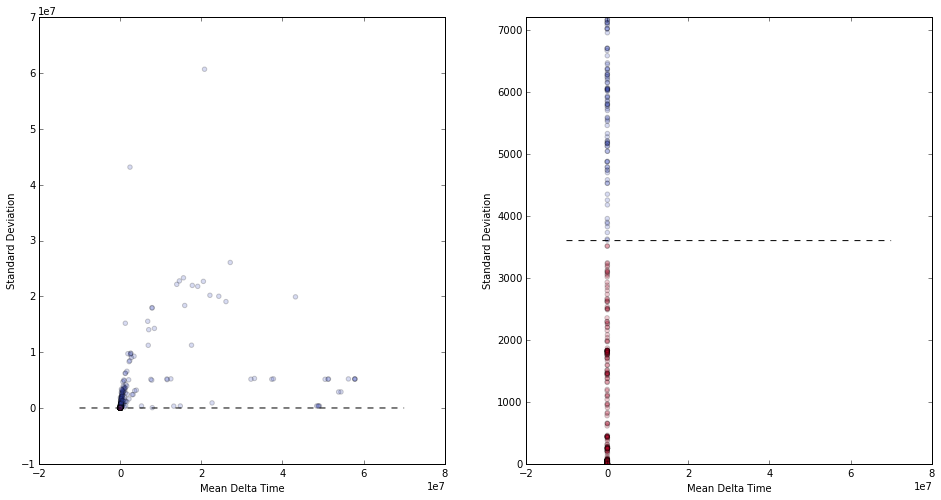

In [6]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 8))
axarr[0].scatter(stat_data[:, 0], stat_data[:, 1],
                 c=stat_data[:, 3], cmap=plt.cm.coolwarm,
                 alpha=0.2)
axarr[1].scatter(stat_data[:, 0], stat_data[:, 1],
                 c=stat_data[:, 3], cmap=plt.cm.coolwarm,
                 alpha=0.2)
domain = np.arange(-1e7, 7e7)
axarr[0].plot(domain, thresh * np.ones(len(domain)), 'k--')
axarr[1].plot(domain, thresh * np.ones(len(domain)), 'k--')
axarr[0].set_xlabel('Mean Delta Time')
axarr[0].set_ylabel('Standard Deviation')
axarr[1].set_xlabel('Mean Delta Time')
axarr[1].set_ylabel('Standard Deviation')
axarr[1].set_ylim(0, thresh * 2)
plt.show()

From this we can interpret several things.

1. The standard deviation of each system is terrible. Only a very small set of systems have consistently "good" data. This means that most systems have bad data.
2. On the other hand, most systems are clustered at the (relative) origin. This is helpful, but many systems are still bad.

Now that we know many systems result in poor data consistency, we can branch out and examine just the rows that we consider "valid", i.e., those rows in which the `delta` field is approximately 86,000 (the length of a day in seconds).

# Good Row Analysis

We start by pulling out only the valid rows. (We also get the "bad" rows, but we'll use those later.)

In [36]:
clean_raw_data = data.values[np.where(np.abs(data.values[:, 5] - 86400) <= 3600)[0]]
dirty_raw_data = data.values[np.where(np.abs(data.values[:, 5] - 86400) > 3600)[0]]

In [18]:
clean_data = pd.DataFrame(clean_raw_data,
                        columns=['date', 'system', 'controller', 'obs_time',
                                 'base_time', 'delta', 'release', 'fw', 'sw'])
print(len(clean_data))
clean_data.head()

522288


,date,system,controller,obs_time,base_time,delta,release,fw,sw
0,1/1/15,1016FG000254,A,1.42015e+09,1.420063e+09,86395,Galena,07.86.34.00,10.86.0G00.0028
1,1/1/15,1017FG000057,A,1.420102e+09,1.420016e+09,86398,Galena,07.86.29.00,10.86.0G08.0017
2,1/1/15,1032FG000284,A,1.420105e+09,1.420018e+09,86395,Galena,07.86.32.00,10.86.0G00.0024
3,1/1/15,1032FG000288,B,1.420074e+09,1.419988e+09,86396,Galena,07.86.34.00,10.86.0G00.0013
4,1/1/15,1032FG000308,A,1.420151e+09,1.420065e+09,86396,Galena,07.86.32.00,10.86.0G00.0024


We see that we've immediately removed half of the rows. This is arguably good. Notice the term "arguably"...

## Reduction Comparison

We'll start by looking at which systems "lost" the most data. We will do this by comparing the system groupings.

In [26]:
original_grouping = data.groupby('system')
clean_grouping = clean_df.groupby('system')
keys = data['system'].unique()

We will now extract the difference from this array.

In [29]:
key_groups = np.zeros((len(clean_data), 2))
i = 0
for k in keys:
    key_groups[i][0] = len(original_grouping.get_group(k))
    try:
        key_groups[i][1] = len(clean_grouping.get_group(k))
    except KeyError:
        pass
    i += 1

In [31]:
key_groups_difference = np.array([kg[0] - kg[1] for kg in key_groups])

And now we can plot this.

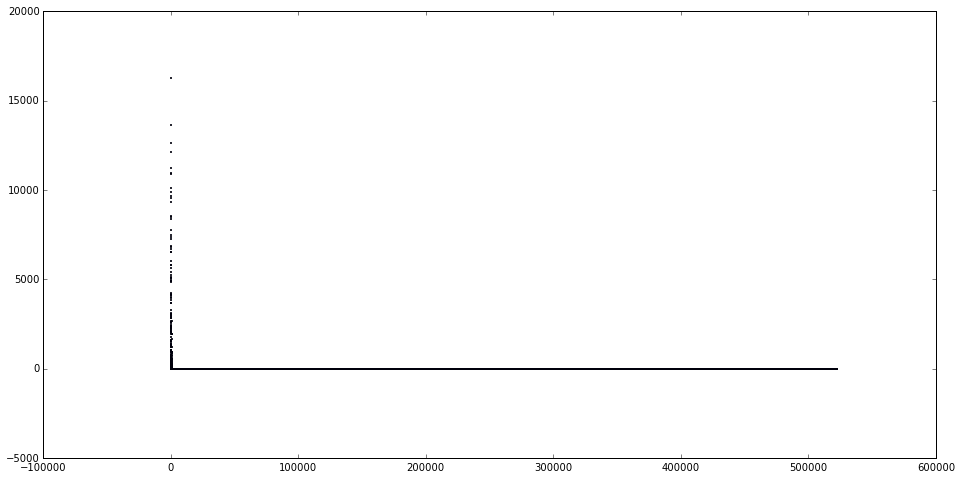

In [35]:
plt.figure(figsize=(16, 8))
plt.scatter(np.arange(len(key_groups_difference)), key_groups_difference, s=1)
plt.show()

From this we can interpret that *most* systems have no change, while very few lose all their data. This result is good enough for our purposes.

# Release Analysis

Now let's look at the dirty data. We will see if the software and firmware versions affect the number of bad rows.

In [37]:
dirty_data = pd.DataFrame(dirty_raw_data,
                        columns=['date', 'system', 'controller', 'obs_time',
                                 'base_time', 'delta', 'release', 'fw', 'sw'])
print(len(dirty_data))
dirty_data.head()

525834


,date,system,controller,obs_time,base_time,delta,release,fw,sw
0,1/1/15,1016FG000432,A,1.420125e+09,1.420092e+09,33447,Galena,07.86.36.30,10.86.0G00.0048
1,1/1/15,1030FG000606,A,1.420112e+09,1.420045e+09,66903,Galena,07.86.45.30,10.86.0G00.0048
2,1/1/15,1030FG000619,A,1.420112e+09,1.420111e+09,666,Galena,07.86.45.30,10.86.0G00.0048
3,1/1/15,1030FG000621,A,1.420112e+09,1.420111e+09,1205,Galena,07.86.45.30,10.86.0G00.0048
4,1/1/15,1030FG000630,A,1.420112e+09,1.420076e+09,36243,Galena,07.86.45.30,10.86.0G00.0048


Now we group by software version. We also convert this to an array, as we're interested in the number of bad values per software version. (Note, we make some assumptions about these software versions. This sorting *may* be incorrect.)

In [77]:
sw_groups = dirty_data.groupby('sw')
sw_data = np.array(sorted([(int(''.join(t[0].split('.')[:2]) + t[0].split('.')[-1]),
                           t[0], len(t[1]))
                          for t in list(sw_groups)],
                    key=lambda t: t[0]))
numeric_sw_data = np.array(sw_data[:, 2], dtype=int)

In [81]:
fw_groups = dirty_data.groupby('fw')
fw_data = np.array([(t[0], len(t[1]))
                    for t in list(fw_groups)
                    if t[0] != 'no storage_array_profile.txt'])
numeric_fw_data = np.array(fw_data[:, 1], dtype=int)

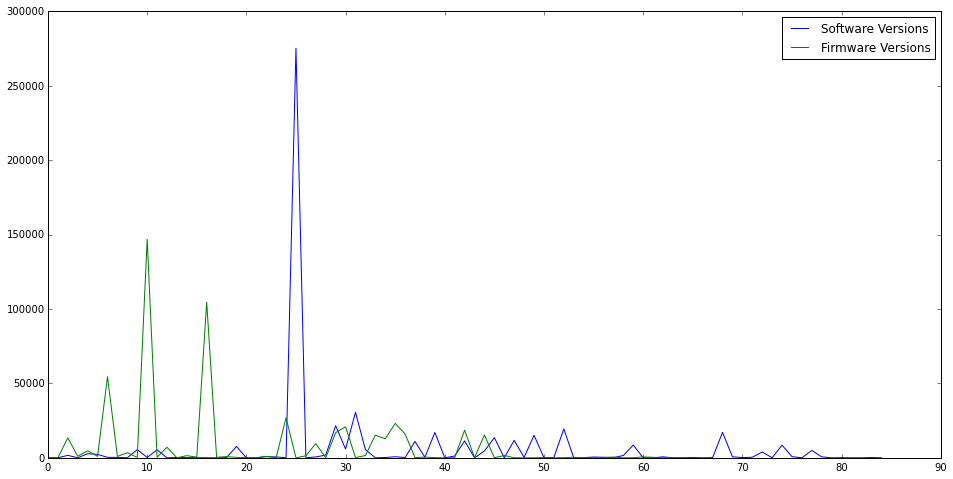

In [83]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(numeric_sw_data)), numeric_sw_data,
            label='Software Versions')
plt.plot(np.arange(len(numeric_fw_data)), numeric_fw_data,
            label='Firmware Versions')
plt.legend()
plt.show()

Hey! That's perfect! That shows that the number of *bad* rows was really really high for specific versions, but have since been reduced to a lower amount. That's exactly what we wanted to see.